In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import itertools
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

In [4]:
df = pd.read_csv('port2011.csv', index_col=0)

In [19]:
df= df.sort_values(by='1', ascending=False)

In [15]:
#Anual closing price
#df['prcc_c']

#marketcap
#df['mkvalt']

#share outstanding
#df['csho']

0       335.268
1        14.516
2       169.601
3       109.246
4        75.640
         ...   
3465     42.765
3466      7.219
3467     56.319
3468     41.308
3469      9.723
Name: csho, Length: 3470, dtype: float64

In [23]:
df['quantile'] = pd.qcut(df['1'],10, labels=["1", "2", "3",'4','5','6','7','8','9','10'])

In [32]:
#store the needed GVKEY into a list
masklow=df['quantile']=='10'
lowlist= list(df[masklow]['GVKEY'])

maskhigh=df['quantile']=='1'
highlist= list(df[maskhigh]['GVKEY'])

In [34]:
all_fund = pd.read_csv('all_companies_fund.csv')

C:\Users\Derrick\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,33,37,955,956,957,962,972,976,977,982) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
all_fund['datadate']=(pd.to_datetime(all_fund['datadate']))
all_fund['month']= all_fund['datadate'].dt.month
all_fund['year']= all_fund['datadate'].dt.year

In [41]:
all_fund['datadate']

0        2001-05-31
1        2002-05-31
2        2003-05-31
3        2004-05-31
4        2005-05-31
            ...    
238116   2018-12-31
238117   2018-12-31
238118   2018-12-31
238119   2018-12-31
238120   2019-12-31
Name: datadate, Length: 238121, dtype: datetime64[ns]

In [45]:
maskyear= all_fund['year']>=2011
all_fund=all_fund[maskyear]

In [96]:
all_fund['month'].value_counts()

12    82039
6      4986
3      4804
9      4729
10     2971
1      2084
8      2030
4      1765
5      1387
7      1367
11     1357
2      1238
Name: month, dtype: int64

In [52]:
#
maskhigh= all_fund['GVKEY'].isin(highlist)
highdata=all_fund[maskhigh]

masklow= all_fund['GVKEY'].isin(lowlist)
lowdata=all_fund[masklow]

In [64]:
highdata['mkvalt']

211        88302.4112
212       103271.6885
213        59338.5963
214        67891.7357
215        66137.3852
             ...     
237659       569.2604
237660       590.1660
237661       608.1250
237662       616.3248
237663       693.7640
Name: mkvalt, Length: 2470, dtype: float64

In [65]:
mask = highdata['GVKEY']==highdata['GVKEY'].shift(-1)
highdata['mkvalt_next']= np.where(mask,highdata['mkvalt'].shift(-1),np.nan)
mask = lowdata['GVKEY']==lowdata['GVKEY'].shift(-1)
lowdata['mkvalt_next']= np.where(mask,lowdata['mkvalt'].shift(-1),np.nan)

C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
highdata['return']= (highdata['mkvalt_next']-highdata['mkvalt'])*100/highdata['mkvalt']
lowdata['return']= (lowdata['mkvalt_next']-lowdata['mkvalt'])*100/lowdata['mkvalt']

C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
# Shift the stock by 1 month
mask = highdata['GVKEY']==highdata['GVKEY'].shift(-1)
highdata['nextmonth_return']= np.where(mask,highdata['return'].shift(-1),np.nan)

# Shift the stock by 1 month
mask = lowdata['GVKEY']==lowdata['GVKEY'].shift(-1)
lowdata['nextmonth_return']= np.where(mask,lowdata['return'].shift(-1),np.nan)

C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## equal weighted portfolio

In [77]:
highdata.groupby(['year','month'])[['nextmonth_return']].agg('mean')
lowdata.groupby(['year','month'])[['nextmonth_return']].agg('mean')
long_short= (highdata.groupby(['year','month'])[['nextmonth_return']].agg('mean'))-(lowdata.groupby(['year','month'])[['nextmonth_return']].agg('mean'))

In [83]:
long_short=long_short.reset_index()


In [87]:
long_short['date']=pd.to_datetime(long_short[['year', 'month']].assign(Day=1))

In [88]:
long_short

,year,month,nextmonth_return,date
0,2011,3,27.888798,2011-03-01
1,2011,6,-75.158470,2011-06-01
2,2011,9,-17.841870,2011-09-01
3,2011,12,-119.338644,2011-12-01
4,2012,3,-13.093828,2012-03-01
5,2012,6,31.402747,2012-06-01
6,2012,9,-34.041112,2012-09-01
7,2012,12,-26.684065,2012-12-01
8,2013,3,10.719356,2013-03-01
9,2013,6,-63.841728,2013-06-01


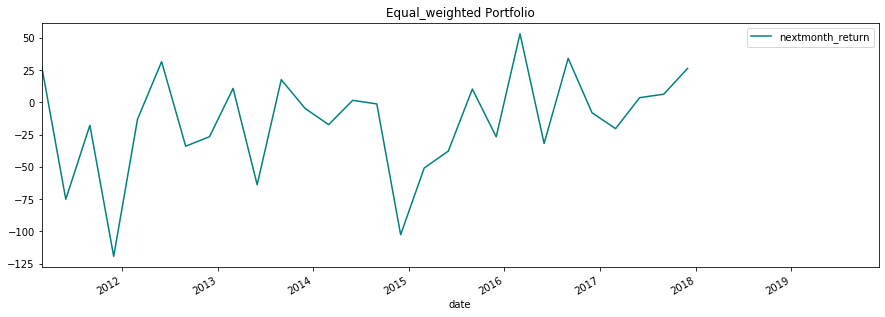

In [92]:
ax = long_short.plot(x = 'date', y = 'nextmonth_return', title = 'Equal_weighted Portfolio', color = 'teal', figsize = (15,5))

## Market Cap Weighted portfolio

## Datareader

In [58]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

start_sp = datetime.datetime(1998, 1 , 1)
end_sp = datetime.datetime(2020, 1, 31)


yf.pdr_override() # <== that's all it takes :-)
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
sp500= sp500.reset_index()

sp500['year']=sp500['Date'].dt.year
sp500['month']=sp500['Date'].dt.month

sp500=sp500.drop_duplicates(subset=['year','month'], keep="last")

sp500['next_month_close']= sp500['Adj Close'].shift(-1)
sp500['mkt_return']= (sp500['next_month_close']-sp500['Adj Close'])*100/sp500['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [97]:
#merge dataframe 
regressiondata= pd.merge(long_short,sp500, left_on=['year','month'], right_on=['year','month'], how='left')

In [98]:
regressiondata

,year,month,nextmonth_return,date,Date,Open,High,Low,Close,Adj Close,Volume,next_month_close,mkt_return
0,2011,3,27.888798,2011-03-01,2011-03-31,1327.439941,1329.770020,1325.030029,1325.829956,1325.829956,3566270000,1363.609985,2.849538
1,2011,6,-75.158470,2011-06-01,2011-06-30,1307.640015,1321.969971,1307.640015,1320.640015,1320.640015,4200500000,1292.280029,-2.147443
2,2011,9,-17.841870,2011-09-01,2011-09-30,1159.930054,1159.930054,1131.339966,1131.420044,1131.420044,4416790000,1253.300049,10.772304
3,2011,12,-119.338644,2011-12-01,2011-12-30,1262.819946,1264.119995,1257.459961,1257.599976,1257.599976,2271850000,1312.410034,4.358306
4,2012,3,-13.093828,2012-03-01,2012-03-30,1403.310059,1410.890015,1401.420044,1408.469971,1408.469971,3676890000,1397.910034,-0.749745
5,2012,6,31.402747,2012-06-01,2012-06-29,1330.119995,1362.170044,1330.119995,1362.160034,1362.160034,4590480000,1379.319946,1.259757
6,2012,9,-34.041112,2012-09-01,2012-09-28,1447.130005,1447.130005,1435.599976,1440.670044,1440.670044,3509230000,1412.160034,-1.978941
7,2012,12,-26.684065,2012-12-01,2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,1426.189941,3204330000,1498.109985,5.042810
8,2013,3,10.719356,2013-03-01,2013-03-28,1562.859985,1570.280029,1561.079956,1569.189941,1569.189941,3304440000,1597.569946,1.808577
9,2013,6,-63.841728,2013-06-01,2013-06-28,1611.119995,1615.939941,1601.060059,1606.280029,1606.280029,4977190000,1685.729980,4.946208


# Regressing the sp500 and equal weighted portfolio

In [99]:
mask= regressiondata['nextmonth_return'].isnull()|regressiondata['mkt_return'].isnull()

In [101]:
import statsmodels.api as sm
x=regressiondata[~mask]['mkt_return']
y=regressiondata[~mask]['nextmonth_return']
x = sm.add_constant(x)

C:\Users\Derrick\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [102]:
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       nextmonth_return   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.5696
Date:                Tue, 03 Mar 2020   Prob (F-statistic):              0.457
Time:                        12:34:29   Log-Likelihood:                -147.37
No. Observations:                  29   AIC:                             298.7
Df Residuals:                      27   BIC:                             301.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.0599      8.423     -2.025      0.0